## Data set 
World Health Organization has estimated 12 million deaths occur worldwide, every year due to Heart diseases. Half the deaths in the United States and other developed countries are due to cardio vascular diseases. The early prognosis of cardiovascular diseases can aid in making decisions on lifestyle changes in high risk patients and in turn reduce the complications. This research intends to pinpoint the most relevant/risk factors of heart disease as well as predict the overall risk. 

### Source
The dataset (framingham.csv) is publically available on the Kaggle website, and it is from an ongoing cardiovascular study on residents of the town of Framingham, Massachusetts. The classification goal is to predict whether the patient went on to develop coronary heart disease (CHD) in a 10 year period. The dataset provides the patients’ information. It includes over 4,000 records and 15 attributes.

### Variables
Each attribute is a potential risk factor. There are both demographic, behavioral and medical risk factors.

* male: Indicator variable for biological sex (1:male 0:female)
* age: Age of the patient in years 
* education: Education level. Ordinal variable.c
* currentSmoker: whether or not the patient is a current smoker (1:yes 0:no)
* cigsPerDay: the number of cigarettes that the person smoked on average in one day
* BPMeds: whether or not the patient was on blood pressure medication (1:yes 0:no)
* prevalentStroke: whether or not the patient had previously had a stroke 
* prevalentHyp: whether or not the patient was hypertensive
* diabetes: whether or not the patient had diabetes
* totChol: total cholesterol level
* sysBP: systolic blood pressure
* diaBP: diastolic blood pressure
* BMI: Body Mass Index
* heartRate: heart rate (beats per minute)
* glucose: glucose level
* TenYearCHD: 10 year risk of coronary heart disease (1: developed signs of CHD in 10 year period, 0: did not develop CHD) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, make_scorer, confusion_matrix, roc_curve, auc
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler
%matplotlib inline

Loading the Dataset framingham.csv *discarding all rows in the data frame that include any NaNs*. 

Splitting the data into equals-sized training and test sets (using a random_state = 0). 


In [2]:
D=pd.read_csv('framingham.csv')
D=D.dropna()

In [3]:
Dtrain, Dtest = train_test_split(D,test_size=0.5,random_state=0)
print('There are',Dtest.shape[0],'observations in the training set.')

There are 1828 observations in the training set.


In [4]:
# baseline rate
Dtest.TenYearCHD.mean()

0.1586433260393873

The baseline rate is 14.86%. 
For a classifier that predicts always 0, the baseline accuracy will be 85.13%, the baseline F1-score will be 0, and baseline Specificity is 1, the baseline Sensitivity is 0, the baseline balanced accuracy is 0.5. 

# Logisitic regression model (without regularization) based on the demographic variables (male, age, education) only. 

In [5]:
LR= LogisticRegression(solver='lbfgs',penalty = 'none',max_iter=10000)
# Make the design matrix 
X = np.c_[Dtrain.male,Dtrain.age,Dtrain.education]
y = Dtrain.TenYearCHD.values
cv_score = cross_val_score(LR,X, y, cv=10, scoring = 'roc_auc')
cv_score.mean()

0.698629702564661

In [6]:
# Make the design matrix 
X = np.c_[Dtrain.age,Dtrain.education]
cv_score = cross_val_score(LR,X, y, cv=10, scoring = 'roc_auc')
cv_score.mean()

0.6878287020170084

In [7]:
# Make the design matrix 
X = np.c_[Dtrain.male,Dtrain.education]
y = Dtrain.TenYearCHD.values
cv_score = cross_val_score(LR,X, y, cv=10, scoring = 'roc_auc')
cv_score.mean()

0.586653540687511

In [8]:
# Make the design matrix 
X = np.c_[Dtrain.male,Dtrain.age]
y = Dtrain.TenYearCHD.values
cv_score = cross_val_score(LR,X, y, cv=10, scoring = 'roc_auc')
cv_score.mean()

0.6988113247514276

Based on the model-based comparision, Age is the most important predictor in this model. Education makes the prediction worse in this case, and can likely be dropped from the model. 

### Question 5 (7pts)
Combine all variables (except the one you want to predict!) into a Logistic regression model without regularization. Using the training set only, determine the average cross-validated log likelihood of the model on the training data, using 10-fold crossvalidation. 

Hint: The log-likelihood for a single observation $y$ and a predicted probability $\hat{y}$ is 
$ log P(y|\hat{y})= y log(\hat{y}) + (1-y) log(1-\hat{y})$ 
and there is a sklearn scoring method that calculates this quantity:
https://scikit-learn.org/stable/modules/model_evaluation.html

In [9]:
X = Dtrain.drop('TenYearCHD', axis='columns').astype('float').values
y = Dtrain.TenYearCHD.values
cv_score = cross_val_score(LR,X, y, cv=10, scoring = 'neg_log_loss')
cv_score.mean()

-0.3759114083380509

**Grading: 2 pts for building the correct design matrix, 5pts for calculating the average log-likelihood correctly (i.e. making the correct connection between neg_log_loss and log-likelihood)**

## Task 2: Regularized Logisitic regression model (27pts) 

### Question 1 (8pts)
Use L1 regularization to determine the best set of variables to include in a predictive model.
Add a penalty of $\lambda \sum_{i}{|\beta_i|_1}$ ($\beta_i$ are your regression coefficients) to the Logistic regression model. Vary the regularization parameter $\lambda$ between 0.2 and 200, evenly spaced in log-space. 

Apply all necessary preprocessing steps to your variables to be able to compare meanfully  between different predictors in the model. 

Plot the coefficient path, i.e. the size of the regression coefficients relative to the size of the the regularization paramter. Which two variables are the two most important predictors of 10-year risk of CHD?   

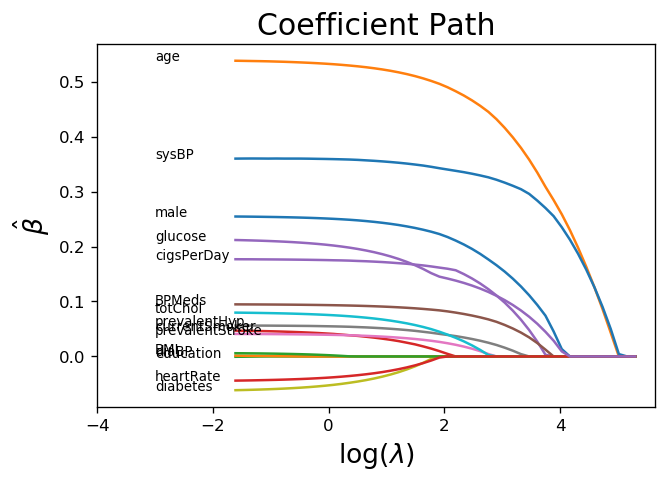

In [10]:
regularization_strength = np.exp(np.linspace(np.log(0.2),np.log(200),50))

coefs = np.zeros((regularization_strength.size, X.shape[1]))

for i,L in enumerate(regularization_strength):
    lasso_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('logistic_regression', LogisticRegression(penalty = 'l1', 
                                               solver='liblinear', 
                                               max_iter=1000,
                                               C = 1.0/L)) # Note, C = 1/lambda from question 3
    ])
    
    lasso_pipe.fit(X, y)
    coefs[i] = lasso_pipe.named_steps['logistic_regression'].coef_    

fig, ax = plt.subplots(dpi = 120)
ax.plot(np.log(regularization_strength), coefs)
ax.set_xlabel(r'$\log(\lambda)$', fontsize = 16)
ax.set_ylabel(r'$\hat{\beta}$', fontsize = 16)
ax.set_title('Coefficient Path', fontsize = 18)
ax.set_xlim(-4,None)

for i, name in enumerate(D.columns[:-1]):
    
    ax.annotate(name, xy = (-3, coefs[0,i]), ha = 'left', fontsize = 8)

The most important variables are age and systolic blood pressure. 

**Grading: 2pts Spacing the regularization correctly, 2pts defining the correct models, 2pts Plot with labels, 2pts conclusion**

### Question 2 (7pts)
Using the same model and the range of regularisation parameters as in T2, Q1, determine the 10-fold crossvalidated performance for different values of the L1-regularisation parameter. Use the cross-validated log-likelihood of the data under the model as evaluation criterion. (If you couldn't calulcate the log-likelihood in Task 1, Question 5, use another suitable evaluation criterion).   

Make a plot of the crossvalidated log-likelihood against $log(\lambda)$. Base on this criterion, what is the optional setting of the L1-regularization parameter? At this value, which variables contribute to the prediction? 


Text(0, 0.5, 'likelihood')

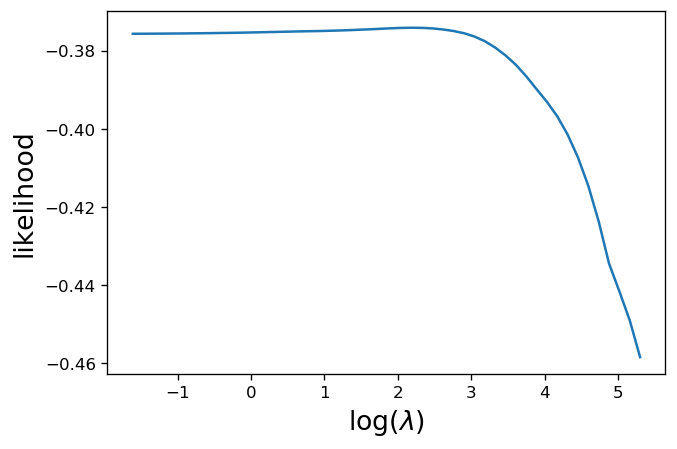

In [11]:
regularization_strength = np.exp(np.linspace(np.log(0.2),np.log(200),50))

loglike = np.zeros((regularization_strength.size,))

for i,L in enumerate(regularization_strength):
    lasso_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('logistic_regression', LogisticRegression(penalty = 'l1', 
                                               solver='liblinear', 
                                               max_iter=1000,
                                               C = 1.0/L)) # Note, C = 1/lambda from question 3
    ])
    
    cv_score = cross_val_score(lasso_pipe,X, y, cv=10, scoring = 'neg_log_loss')
    loglike[i]= cv_score.mean()

fig, ax = plt.subplots(dpi = 120)
ax.plot(np.log(regularization_strength), loglike)
ax.set_xlabel(r'$\log(\lambda)$', fontsize = 16)
ax.set_ylabel(r'likelihood', fontsize = 16)


In [12]:
bestI=np.argmax(loglike)
print('Best lambda:',regularization_strength[bestI])
print('Variables included:',Dtrain.drop('TenYearCHD', axis='columns').columns[coefs[bestI]!=0])

Best lambda: 8.99686533793889
Variables included: Index(['male', 'age', 'cigsPerDay', 'BPMeds', 'prevalentStroke',
       'prevalentHyp', 'totChol', 'sysBP', 'glucose'],
      dtype='object')


**Grading: No subtracted points for carried over mistakes from last question. 2pts for right evaluation, 2pts for plot, 1pts for best lambda, 2pts for correct variables** 

### Question 3 (6pts)
Using the best lambda that you found, fit the L1-regularized model to all the training data and then get the the predicted probability for each item of the test set. 

Plot the ROC curve for the test set and model.

Report the area under the ROC curve. 

Text(0, 0.5, 'True positive rate')

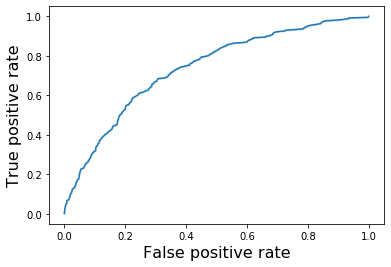

In [13]:
# Plot ROC Curve
Xtest = Dtest.drop('TenYearCHD', axis='columns').astype('float').values
ytest = Dtest.TenYearCHD.values

lasso_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('logistic_regression', LogisticRegression(penalty = 'l1', solver='liblinear', 
                                               max_iter=1000,C = 1.0/8.9968))])

Fit = lasso_pipe.fit(X,y)
y_pred = Fit.predict_proba(Xtest)
y_pred[:,1].mean()
fpr, tpr, _ = roc_curve(ytest, y_pred[:,1])
ax=sns.lineplot(fpr,tpr)
ax.set_xlabel('False positive rate', fontsize = 16)
ax.set_ylabel('True positive rate', fontsize = 16)


In [14]:
print('The area under the ROC curve is',np.round(auc(fpr,tpr),4))

The area under the ROC curve is 0.7366


**Grading: 1pt for correctly fitted model, 2 pts for correct probability, 1 pt for roc curve calculation, 1pt for plotting and labels, 1 pt for AUC.** 

### Question 4 (6pts)
Given the resulting ROC-curve, if you wanted your predictive model to have a sensitivity of more than 0.8, what is the best specificity you could achieve on the test set? 

Provide the 95% confidence interval on the specificity. Note that there are different ways of getting a valid confidence interval, including the normal approximation (central limit theorem) to the binomial distribution or bootstrap (see Lab, week 3 for hints). 

In [15]:
# Get lowest FPR for a TPR of above 0.8
spec = 1-np.min(fpr[tpr>0.8])
print('The specificity is ', np.round(spec,4))

The specificity is  0.526


In [20]:
# Here I'm using the normal approximation to the binomial distribution
# P is 1-FPR
# N is the number of class negatives (see Lecture 8, slide 33,34)
# For other solutions, see Lab of week 4
N = np.sum(ytest==0)
stderr =np.sqrt(spec*(1-spec)/N)
critval = 1.96
norm_ci = [spec - critval*stderr, 
           spec + critval*stderr]
print(f"Norm ci: {norm_ci}")

Norm ci: [0.5010526863311713, 0.5509629183502331]


**Grading: 3pts for correct specificity, 3pts for CI** 

## Task 3: Deep learning (26pts)
In this task we are looking to see if we can beat the best logistic regression model, using "deep" learning.
### Question 1 (7 pts)
Build a simple linear model with 15 input units for the 15 predictor variables in the CHD data set and two output units for the two output classes (0: no CHD risk, 1: CHD risk). Use a LogSigmoid as your output non-linearity. 

Use the training data set (task 1, Question 1) to train the network:
* Z-standarize your input variables 
* Use the Cross-entropy loss as a training criterion (same as for logisitic regression) 
* Use Stochastic gradient descent optimizer with a learning rate of 0.01
* Run the optimization for 10000 iterations and record the loss for each iteration 
* Make a plot of iterations vs. loss 

Text(0, 0.5, 'Cross entropy loss')

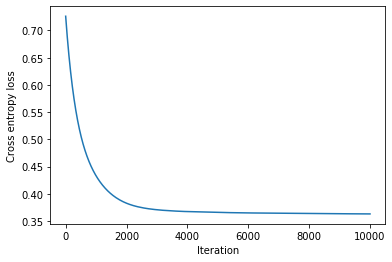

In [8]:
import torch
class LinearModel(torch.nn.Module):
    
    def __init__(self, num_features, num_classes):
        
        super().__init__()
        
        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=num_classes)
        self.activation = torch.nn.LogSigmoid()
    
    def forward(self, X):
        X = self.dense1(X)
        X = self.activation(X)
        return X


X = Dtrain.drop('TenYearCHD', axis='columns').astype('float').values
y = Dtrain.TenYearCHD.values
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
model = LinearModel(15,2)
Xt = torch.FloatTensor(Xs)
yt = torch.LongTensor(y)
y_pred = model.forward(Xt)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

max_iter = 10000
lossRecord = np.zeros(max_iter)

for i in range(max_iter):
    # Intialize the gradient 
    optimizer.zero_grad()
    # Get current 
    y_pred = model.forward(Xt) # Get a forward pass with gradient 
    loss = criterion(input=y_pred, target=yt) # Caluculate the loss  
    lossRecord[i]=loss
    loss.backward() # propagate the derivative backwards 
    optimizer.step() # Take one updating step

plt.plot(np.arange(max_iter),lossRecord)
plt.xlabel('Iteration')
plt.ylabel('Cross entropy loss')

**Grading**
* 1pt: Z-standarize your input variables 
* 2pt: Use the Cross-entropy loss as a training criterion (same as for logisitic regression) 
* 1pt: Use Stochastic gradient descent optimizer with a learning rate of 0.01
* 2pt: Run the optimization for 10000 iterations and record the loss for each iteration 
* 1pt: Make a plot of iterations vs. loss 

### Question 2 (8pts)
Use the trained network to make a prediction for the test set. Report an area under the ROC curve for the test data set. 

HINT: To obtain a probability from the output of the network, take the logistic function of the difference between the activities of the two output units. Remember the output unit 0 is high when the model "thinks" is class is 0 and the output unit 1 is higher when the model "thinks" the class is 1.   

In [10]:
Xtest = Dtest.drop('TenYearCHD', axis='columns').astype('float').values
ytest = Dtest.TenYearCHD.values
Xtt = torch.FloatTensor(scaler.transform(Xtest))

with torch.no_grad():
    y_pred = model.forward(Xtt)
    
yp = y_pred.numpy()
p = 1/(1+np.exp(-yp[:,1]+yp[:,0]))

fpr, tpr, _ = roc_curve(ytest, p)
print('The area under the ROC curve is',np.round(auc(fpr,tpr),4))

The area under the ROC curve is 0.7357


**Grading: 1pt correct scaling, 1pts correct forward pass, 4pts for correct probability, 2 pts for AUC**  

### Question 3 (6pts)
Now add a hidden layer with 50 units into the network. Use a LogSigmoid non-linearity for the hidden layer. Leave all the other parameters the same as for Question 1. Again, plot the loss as a function of the iteration. 

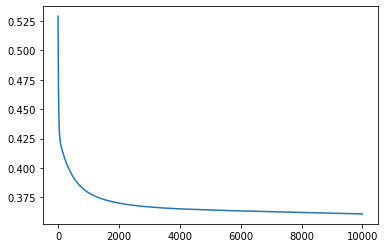

In [266]:
class NonLinearModel(torch.nn.Module):
    
    def __init__(self, num_features, num_classes):
        
        super().__init__()
        
        # Neural Network Architecture: 40 hidden units 
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=50)
        self.activation1 = torch.nn.LogSigmoid()
        self.dense2 = torch.nn.Linear(in_features=50, out_features=num_classes)
        self.activation2 = torch.nn.LogSigmoid()
        
    def forward(self, X):
        X = self.dense1(X)  
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        return X
    
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
model = NonLinearModel(15,2)
Xt = torch.FloatTensor(Xs)
yt = torch.LongTensor(y)
y_pred = model.forward(Xt)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

max_iter = 10000
lossRecord = np.zeros(max_iter)

for i in range(max_iter):
    # Intialize the gradient 
    optimizer.zero_grad()
    # Get current 
    y_pred = model.forward(Xt) # Get a forward pass with gradient 
    loss = criterion(input=y_pred, target=yt) # Caluculate the loss  
    lossRecord[i]=loss
    loss.backward() # propagate the derivative backwards 
    optimizer.step() # Take one updating step

plt.plot(np.arange(max_iter),lossRecord)

**Grading**
* 2pts: Nonlinearity correctly  
* 2pt: Hidden layer correctly specified 
* 1pt: Training correct 
* 1pt: Plot (+ correct labels)  

### Question 4 (5pts)
As for Question 2, report the area under the ROC curve for this network on the test set. 

Written answer: What do you conclude? 

In [267]:
Xtt = torch.FloatTensor(scaler.transform(Xtest))

with torch.no_grad():
    y_pred = model.forward(Xtt)
    
yp = y_pred.numpy()
p = 1/(1+np.exp(-yp[:,1]+yp[:,0]))

fpr, tpr, _ = roc_curve(ytest, p)
print('The area under the ROC curve is',np.round(auc(fpr,tpr),4))

The area under the ROC curve is 0.7296


Even though the network has the capacity to learn non-linear interaction between some of the variables, it did not do appreciably better than the linear model. This could mean that there are no non-linear interactions present in the data, or that a deeper network is needed to reveal them.  